# This CNN has been abandoned because I forgot that the model is multi-output.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras import layers, models
from keras import regularizers
from keras.layers.normalization import BatchNormalization

import train_valid_test as tvt
import plotting

/Users/jinli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Size of Train Set is: 40000
Size of Validation Set is: 10000
Size of Test Set is: 10000


In [2]:
#train.keys()

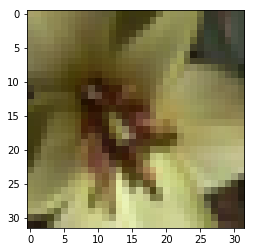

In [3]:
# just to check if I reshaped correctly
index = 5
test_image = tvt.test_X[index]
#test_class = test_fine_y[index]
#test_super_class = test_coarse_y[index]
#print (fine_labels[test_class])
#print (coarse_labels[test_super_class])
plt.imshow(test_image)
plt.show()

In [4]:
batch_size = 100
epochs = 20

In [5]:
# try gray scale?
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(
        32,
        (6, 6),
        activation='relu',
        input_shape=(32, 32, 3)
    ))

    model.add(layers.MaxPool2D(
        (4, 4)
    ))

    model.add(BatchNormalization())

    model.add(layers.SeparableConv2D(
        32, 3,
        activation='relu',
        input_shape=(20, 20, 3)
    ))

    model.add(layers.Flatten())

    model.add(layers.Dense(
        64,
        kernel_regularizer=regularizers.l2(0.001),
        #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
        activation='relu'
    ))

    model.add(layers.Dropout(.5))
    model.add(layers.Dense(100, activation='softmax'))
    return model


model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 32)        3488      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 32)          128       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 4, 4, 32)          1344      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [6]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_X_aug = train_datagen.flow(tvt.train_X, tvt.train_fine_y, batch_size=batch_size)

valid_datagen = ImageDataGenerator()
valid_fine_y_aug = valid_datagen.flow(tvt.valid_X, tvt.valid_fine_y, batch_size=batch_size)

#training_set

In [7]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, \
                            EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('CNN2')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay) # can place this in call_backs_list

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=5)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [8]:
from keras import optimizers
model.compile(#optimizer='rmsprop',
              optimizer=optimizers.RMSprop(lr=1e-4),
             loss='categorical_crossentropy',
            
             metrics=['accuracy'])

In [9]:
history = model.fit_generator(train_X_aug,
                               validation_data=valid_fine_y_aug,
                               #steps_per_epoch= round (len(tvt.train_X) / batch_size),
                               steps_per_epoch= 5,
                               epochs=epochs,
                               #validation_steps=round (len(tvt.valid_X) / batch_size),
                               validation_steps=5,
                               callbacks=callbacks_list)

Epoch 1/20
5/5 [==============================] - 2s 397ms/step - loss: 4.7426 - acc: 0.0020 - val_loss: 4.7256 - val_acc: 0.0080

Epoch 00001: val_loss improved from inf to 4.72562, saving model to CNN2_weights.best.hdf5
Epoch 2/20
5/5 [==============================] - 2s 304ms/step - loss: 4.7256 - acc: 0.0080 - val_loss: 4.7231 - val_acc: 0.0040

Epoch 00002: val_loss improved from 4.72562 to 4.72310, saving model to CNN2_weights.best.hdf5
Epoch 3/20
5/5 [==============================] - 1s 197ms/step - loss: 4.7430 - acc: 0.0120 - val_loss: 4.7336 - val_acc: 0.0060

Epoch 00003: val_loss did not improve from 4.72310

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/20
5/5 [==============================] - 1s 158ms/step - loss: 4.7217 - acc: 0.0080 - val_loss: 4.7303 - val_acc: 0.0020

Epoch 00004: val_loss did not improve from 4.72310
Epoch 5/20
5/5 [==============================] - 1s 158ms/step - loss: 4.7347 - acc: 0.0140 - val_loss: 4

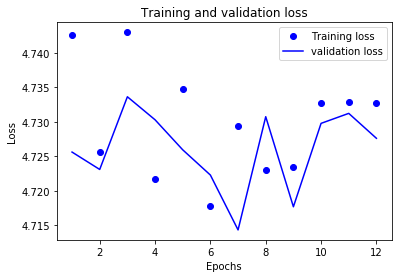

In [10]:
plotting.plot_loss(history)

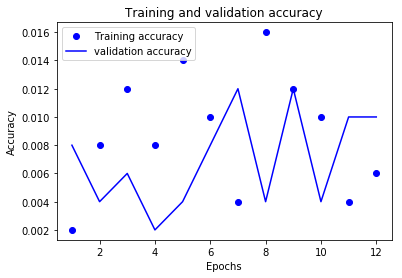

In [11]:
plt.clf()
plotting.plot_acc(history)

In [12]:
model.evaluate(tvt.test_X, tvt.test_fine_y)

10000/10000 [==============================] - 6s 570us/step


[4.723921531677246, 0.0084]

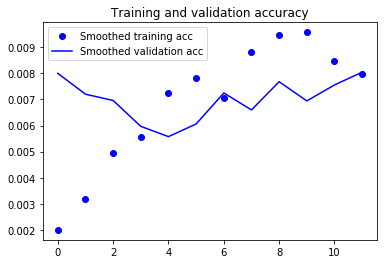

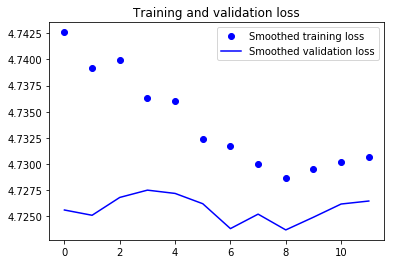

In [13]:
plotting.plot_smooth(history)

NameError: name 'acc' is not defined